In [1]:
import os
import glob
from natsort import natsorted
from tqdm import tqdm
import itertools

import pandas as pd
import numpy as np

from nilearn import image, plotting, datasets, surface
import nibabel as nib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import spearmanr, sem
from sklearn.manifold import MDS

import imageio

/Applications/anaconda3/envs/nilearn/lib/python3.6/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


# Functions

In [2]:
def plot_mds(out_name, images, mds):
    fig, ax = plt.subplots(figsize=(20,20), dpi=80)
    x, y = mds[:,0], mds[:,1]
    ax.scatter(x, y) 
    for x0, y0, image in zip(x, y, images):
        ab = AnnotationBbox(OffsetImage(image, zoom=0.1), (x0, y0), frameon=False)
        ax.add_artist(ab)
    plt.axis('off')
    plt.savefig(out_name)
    plt.close()

In [3]:
def compute_rdm(data, flat=True):
    std = data.std(axis=0) != 0
    data = data[:, std]
    rdm = 1 - np.corrcoef(data)
    if flat: 
        rows, cols = np.tril_indices(len(rdm))
        rdm = rdm[rows, cols]
    return rdm

# Set up paths

In [4]:
bids_dir = '/Users/emcmaho7/Desktop/SI_fMRI'
derivatives_dir = f'{bids_dir}/derivatives'
nilearn_dir = f'{derivatives_dir}/nilearn'
reliability_dir = f'{derivatives_dir}/reliability'
mask_dir = f'{derivatives_dir}/ROI_masks'
rsa_dir = f'{derivatives_dir}/RSA'
fsaverage = datasets.fetch_surf_fsaverage()

# Loading

## Features

### AlexNet

In [5]:
features = []
categories = []
feature_rdms = []
for layer in [1, 5]:
    alexnet = np.load(f'alexnet_conv{layer}_avgframe.npy')
    features.append(f'AlexNet conv{layer}')
    categories.append('visual')
    alexnet_rdm = compute_rdm(alexnet.T)
    feature_rdms.append(alexnet_rdm)

### Optic Flow

In [6]:
features.append(f'optic flow')
categories.append('visual')
of_rdm = compute_rdm(np.load(f'opticflow.npy'))
feature_rdms.append(of_rdm)

### Rated features

In [7]:
bdf = pd.read_csv('/Users/emcmaho7/Dropbox/projects/SI_fmri/experiment/SIdyads_presentation/train_features.csv')
bdf.sort_values(by=['video_name'], inplace=True)
categories.extend(['visual', 'visual',  'visual', 'visual',
            'social detection', 'social detection',
            'social evaluation', 'social evaluation', 'social evaluation', 'social evaluation', 'social evaluation'])
bdf_features = ['indoor', 'expanse_videos', 'distance', 'object', 
            'joint_videos', 'communicating',
            'cooperation', 'dominance', 'relation', 'valence', 'arousal']
features.extend(['indoor', 'expanse', 'agent distance', 'transitivity', 
            'joint action', 'communicating',
            'cooperation', 'dominance', 'relation', 'valence', 'arousal'])

for feature in bdf_features:
    vec = np.expand_dims(bdf[feature].to_numpy(), axis=1)
    rdm = euclidean_distances(vec)
    rows, cols = np.tril_indices(len(rdm))
    feature_rdms.append(rdm[rows, cols])

## Video frames

In [8]:
vid_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/experiment/SIdyads_presentation/social_dyad_videos_500ms/videos'
frames = []
names = []
for vid in tqdm(bdf.video_name, total=len(bdf)):
    names.append(vid.split('.mp4')[0])
    vid = imageio.get_reader(f'{vid_dir}/{vid}', 'ffmpeg')
    frames.append(vid.get_data(0))

100%|██████████| 200/200 [00:14<00:00, 14.10it/s]


## Zmaps

In [9]:
fname = f'{nilearn_dir}/sub-all_task-SIdyads_desc-train_stat-z_statmap.npy'
z_maps = np.load(fname)
n_subjs = z_maps.shape[0]

## Rhos

In [ ]:
def plot_on_surface(rho_map, fsaverage, sid, out_dir):
    #Right hemisphere
    hemi = 'right'
    texture = surface.vol_to_surf(rho_map, fsaverage.pial_right)
    for view in ['lateral', 'ventral', 'medial']:
        out_name = f'{out_dir}/sub-{sid}_desc-train_stat-rho_view-{view}_hemi-{hemi}.pdf'
        plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi=hemi,
                                    colorbar=True, threshold=0.139,
                                    bg_map=fsaverage.sulc_right,
                                    view=view, output_file=out_name)

    #Left hemisphere
    hemi = 'left'
    texture = surface.vol_to_surf(rho_map, fsaverage.pial_left)
    for view in ['lateral', 'ventral', 'medial']:
        out_name = f'{out_dir}/sub-{sid}_desc-train_stat-rho_view-{view}_hemi-{hemi}.pdf'
        plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi=hemi,
                                    colorbar=True, threshold=0.139,
                                    bg_map=fsaverage.sulc_left,
                                view=view, output_file=out_name)

In [ ]:
fname = f'{nilearn_dir}/sub-all_task-SIdyads_desc-train_stat-rho_statmap.npy'
rho_maps = np.load(fname)

In [ ]:
affine = np.array([[   1.92900002,    0.        ,    0.        ,  -96.5       ],
       [   0.        ,    1.92900002,    0.        , -132.5       ],
       [   0.        ,    0.        ,    2.        ,  -78.5       ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])
shape = (101, 120, 97)

In [ ]:
rho_map = nib.Nifti1Image(rho_maps.mean(axis=0).reshape(shape), affine)
plot_on_surface(rho_map, fsaverage, 'all', reliability_dir)

/Applications/anaconda3/envs/nilearn/lib/python3.6/site-packages/nilearn/surface/surface.py:467: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Applications/anaconda3/envs/nilearn/lib/python3.6/site-packages/nilearn/surface/surface.py:467: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


# Cross-subject Reliability

In [14]:
rois = ['EVC', 'MT', 'EBA', 'PPA', 'TOS', 'RSC', 'LOC',  'FFA', 'OFA', 'faceSTS', 'biomotion', 'SIpSTS', 'TPJ', 'DMPFC']
roi_names = ['EVC', 'MT', 'EBA', 'PPA', 'OPA', 'RSC', 'LOC',  'FFA', 'OFA', 'faceSTS', 'biomotion', 'SIpSTS', 'TPJ', 'DMPFC']

In [15]:
lower_all = []
upper_all = []
for roi, roi_name in zip(rois, roi_names):
    rdm = np.zeros((of_rdm.shape[0], 4))
    for sid_ in range(n_subjs): 
        sid = str(sid_+1).zfill(2)
        #activity in ROI
        mask = image.load_img(glob.glob(f'{mask_dir}/sub-{sid}/*region-{roi}*nii.gz')[0])
        mask = np.array(mask.dataobj, dtype='bool').flatten()
        roi_activation = z_maps[sid_, mask, :]

        #Remove nan values (these are voxels that do not vary across the different videos)
        inds = ~np.any(np.isnan(roi_activation), axis=1)
        roi_activation = roi_activation[inds, ...]

        #RDM
        rdm[..., sid_] = compute_rdm(roi_activation.T)
    
    cur_lower = []
    cur_upper = []
    for sid_ in range(n_subjs): 
        #define the indices for the lower bound
        inds = np.arange(n_subjs, dtype='int')
        inds = np.append(inds[:sid_], inds[sid_+1:])

        #compute the current lower (exclusive) and upper (inclusive) bounds
        lower, _ = spearmanr(rdm[..., inds].mean(axis=-1), rdm[..., sid_])
        upper, _ = spearmanr(rdm.mean(axis=-1), rdm[..., sid_])
        
        cur_lower.append(lower)
        cur_upper.append(upper)
        
    lower_all.append(cur_lower)
    upper_all.append(cur_upper)

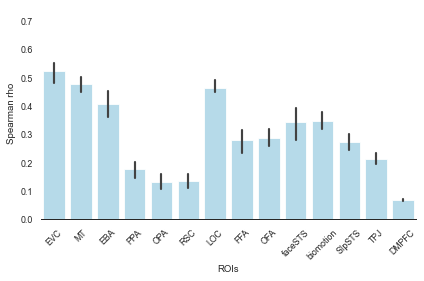

In [16]:
subjects = [f'sub-{i+1:02d}' for i in range(n_subjs)]

lower_all = np.array(lower_all)
df = pd.DataFrame(lower_all.T, columns=roi_names, index=subjects)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Subjects'}, inplace=True)
df = pd.melt(df, id_vars='Subjects', 
         var_name='ROIs',
         value_vars=roi_names, value_name='Spearman rho')

sns.set(style='white', context='paper')
fig, ax = plt.subplots()
sns.barplot(x='ROIs', y='Spearman rho',
        data=df, ax=ax, color='#ADDDF2')
# g = sns.stripplot(x='ROIs', y='Spearman rho', 
#               data=df, ax=ax,
#               size=8,
#               color='#0F2357')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
# sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
ax.set_ylim([0, 0.75])
sns.despine(left=True)
plt.tight_layout()

In [17]:
noise_ceiling = pd.DataFrame()
for cur, bound in zip([upper_all, lower_all], ['upper', 'lower']):
    cur = np.array(cur)
    cur = pd.DataFrame(cur.T, columns=roi_names, index=subjects)
    cur.reset_index(inplace=True)
    cur.rename(columns={'index': 'Subjects'}, inplace=True)
    cur = pd.melt(cur, id_vars='Subjects', 
             var_name='ROIs',
             value_vars=roi_names, value_name='Spearman rho')
    cur['bound'] = bound
    noise_ceiling = noise_ceiling.append(cur).reset_index(drop=True)
noise_ceiling = noise_ceiling.groupby(['ROIs', 'bound']).mean().reset_index()

# Within subject reliability

In [18]:
within = pd.DataFrame()
for roi, roi_name in zip(rois, roi_names):
    for sid_ in range(n_subjs): 
        sid = str(sid_+1).zfill(2)
        #activity in ROI
        mask = image.load_img(glob.glob(f'{mask_dir}/sub-{sid}/*region-{roi}*nii.gz')[0])
        mask = np.array(mask.dataobj, dtype='bool').flatten()
        roi_activation = z_maps[sid_, mask, :]
        rhos = rho_maps[sid_, mask]

        #Remove nan values (these are voxels that do not vary across the different videos)
        inds = ~np.any(np.isnan(roi_activation), axis=1)
        
        within = within.append({'Subjects': f'sub-{sid}',
                               'ROIs': roi_name, 
                               'Spearman rho': rhos[inds].mean()}, ignore_index=True)

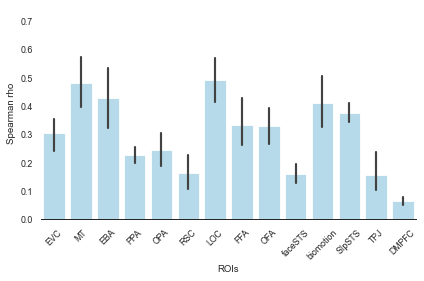

In [19]:
sns.set(style='white', context='paper')
fig, ax = plt.subplots()
sns.barplot(x='ROIs', y='Spearman rho',
        data=within, ax=ax, color='#ADDDF2')
# g = sns.stripplot(x='ROIs', y='Spearman rho', 
#               hue='Subjects',
#               data=within, ax=ax,
#               size=8,
#               palette=sns.color_palette('cubehelix', 6))
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
# sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
ax.set_ylim([0, 0.75])
sns.despine(left=True)
plt.tight_layout()

# ROI RSA Multivariate

In [20]:
df = pd.DataFrame()
for sid_ in range(n_subjs): 
    sid = str(sid_+1).zfill(2)
    for roi, roi_name in zip(rois, roi_names):
        #activity in ROI
        mask = image.load_img(glob.glob(f'{mask_dir}/sub-{sid}/*region-{roi}*nii.gz')[0])
        mask = np.array(mask.dataobj, dtype='bool').flatten()
        roi_activation = z_maps[sid_, mask, :]
        
        #Remove nan values (these are voxels that do not vary across the different videos)
        inds = ~np.any(np.isnan(roi_activation), axis=1)
        roi_activation = roi_activation[inds, ...]
        
        #RDM and MDS
        rdm = compute_rdm(roi_activation.T)
        
        #RSA
        rhos = []
        for category, (feature, feature_rdm) in zip(categories, zip(features, feature_rdms)):
            rho, _ = spearmanr(rdm, feature_rdm)
            df = df.append({'Subjects': f'sub-{sid}',
                            'ROIs': roi_name,
                            'Features': feature,
                            'Category': category,
                            'Spearman rho': rho},
                           ignore_index=True)

In [21]:
colors = ['#48D4E1', '#8C55FD', '#FADC00']
cmap = sns.color_palette(colors, as_cmap=True)

In [22]:
for roi in df.ROIs.unique():
    #Get current ROI data frame
    cur = df[df.ROIs == roi]

    #Set up figures
    sns.set(style='white', context='paper')
    fig, ax = plt.subplots()

    #Plot bars and dots
    g = sns.barplot(x='Features', y='Spearman rho',
                data=cur, ax=ax, 
                hue='Category',
                palette=cmap,
                dodge=False)
    sns.stripplot(x='Features', y='Spearman rho', 
                      data=cur, ax=ax, color='gray')

    #Plot noise ceiling
    x = np.arange(-1, len(ax.get_xticklabels())+1)
    y1 = np.ones_like(x)*noise_ceiling.loc[(noise_ceiling.ROIs == roi) & (noise_ceiling.bound == 'lower'), 'Spearman rho'].tolist()[0]
    #     y2 = np.ones_like(x)*noise_ceiling.loc[(noise_ceiling.ROIs == roi) & (noise_ceiling.bound == 'upper'), 'Spearman rho'].tolist()[0]
    ax.plot(x, y1, color='gray', alpha=0.5, linewidth=3)

    # #Aesthetics
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel('Spearman rho', fontsize=14)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlim([-1, len(ax.get_xticklabels())])
    sns.despine(left=True)
    plt.title(roi, fontsize=18)
    plt.tight_layout()
    plt.legend([],[], frameon=False)
    plt.savefig(f'{rsa_dir}/sub-all_region-{roi}_bars.pdf')
    plt.close()
    
#     ps = []
#     ts = []
#     for feature in features:
#         f = cur[cur.Features == feature]
#         t, p = ttest_1samp(f['Spearman rho'], popmean=0)
#         ps.append(p)
#         ts.append(t)
#     result = multipletests(ps, method='fdr_bh')
#     ps_corrected = result[1]
#     ps_bool = result[0]
    
#     for p, feature in zip(ps_bool, features):
#         if not p:
#             print(f'ROI: {roi}, feature: {feature}')

# ROI RSA Univariate

In [23]:
df = pd.DataFrame()
for sid_ in range(n_subjs): 
    sid = str(sid_+1).zfill(2)
    for roi, roi_name in zip(rois, roi_names):
        #activity in ROI
        mask = image.load_img(glob.glob(f'{mask_dir}/sub-{sid}/*region-{roi}*nii.gz')[0])
        mask = np.array(mask.dataobj, dtype='bool').flatten()
        roi_activation = z_maps[sid_, mask, :]
        
        #Remove nan values (these are voxels that do not vary across the different videos)
        inds = ~np.any(np.isnan(roi_activation), axis=1)
        roi_activation = roi_activation[inds, ...]
        
        #RDM and MDS
        vec = np.expand_dims(roi_activation.mean(axis=0), axis=1)
        rdm = euclidean_distances(vec)
        rows, cols = np.tril_indices(len(rdm))
        rdm = rdm[rows, cols]
        
        #RSA
        rhos = []
        for category, (feature, feature_rdm) in zip(categories, zip(features, feature_rdms)):
            rho, _ = spearmanr(rdm, feature_rdm)
            df = df.append({'Subjects': f'sub-{sid}',
                            'ROIs': roi_name,
                            'Features': feature,
                            'Category': category,
                            'Spearman rho': rho},
                           ignore_index=True)

In [24]:
colors = ['#48D4E1', '#8C55FD', '#FADC00']
cmap = sns.color_palette(colors, as_cmap=True)

In [26]:
for roi in df.ROIs.unique():
    #Get current ROI data frame
    cur = df[df.ROIs == roi]

    #Set up figures
    sns.set(style='white', context='paper')
    fig, ax = plt.subplots()

    #Plot bars and dots
    g = sns.barplot(x='Features', y='Spearman rho',
                data=cur, ax=ax, 
                hue='Category',
                palette=cmap,
                dodge=False)
    sns.stripplot(x='Features', y='Spearman rho', 
                      data=cur, ax=ax, color='gray')

    #Plot noise ceiling
    x = np.arange(-1, len(ax.get_xticklabels())+1)
    y1 = np.ones_like(x)*noise_ceiling.loc[(noise_ceiling.ROIs == roi) & (noise_ceiling.bound == 'lower'), 'Spearman rho'].tolist()[0]
    #     y2 = np.ones_like(x)*noise_ceiling.loc[(noise_ceiling.ROIs == roi) & (noise_ceiling.bound == 'upper'), 'Spearman rho'].tolist()[0]
    ax.plot(x, y1, color='gray', alpha=0.5, linewidth=3)

    # #Aesthetics
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel('Spearman rho', fontsize=14)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlim([-1, len(ax.get_xticklabels())])
    sns.despine(left=True)
    plt.title(roi, fontsize=18)
    plt.tight_layout()
    plt.legend([],[], frameon=False)
    plt.savefig(f'{rsa_dir}/sub-all_region-{roi}_bars_univariate.pdf')
    plt.close()

# MDS

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# for roi, roi_name in zip(rois, roi_names):
#     rdm = np.zeros((200, 200, 4))
#     for sid_ in range(n_subjs): 
#         sid = str(sid_+1).zfill(2)
#         #activity in ROI
#         mask = image.load_img(glob.glob(f'{mask_dir}/sub-{sid}/*region-{roi}*nii.gz')[0])
#         mask = np.array(mask.dataobj, dtype='bool').flatten()
#         roi_activation = z_maps[sid_, mask, :]

#         #Remove nan values (these are voxels that do not vary across the different videos)
#         inds = ~np.any(np.isnan(roi_activation), axis=1)
#         roi_activation = roi_activation[inds, ...]

#         #RDM and MDS
#         rdm[..., sid_] = compute_rdm(roi_activation.T, flat=False)

#     points = TSNE(metric='precomputed', square_distances=True).fit_transform(rdm.mean(axis=-1))
#     plot_mds(f'{rsa_dir}/sub-all_region-{roi}_mds.pdf', frames, points)
